# 「五山送り火」に隠された都市伝説レイライン

## 過去・現在に至る「送り火」を地図上に描くPython コード


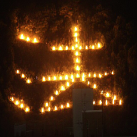
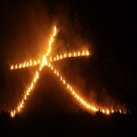
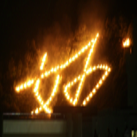
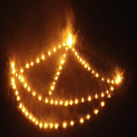
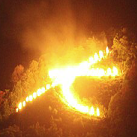
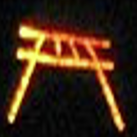
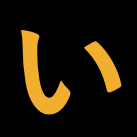
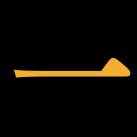
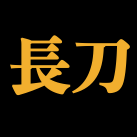
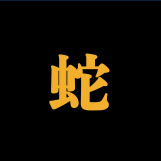

In [1]:
import folium
locs={
'相国寺':{'loc':[35.033, 135.762],'icon':None}, 
'法(大黒天山)':{'loc':[35.054,135.786],'icon':'icon_hou.png'},
'大(如意ヶ嶽・大文字山)':{'loc':[35.023,135.804],'icon':'icon_migi.png'},
'妙(万灯籠山)':{'loc':[35.055, 135.775],'icon':'icon_myo.png'},
'舟形万灯籠(船山)':{'loc':[35.066, 135.734],'icon':'icon_fune.png'},
'左大(大文字山)':{'loc':[35.043, 135.731],'icon':'icon_hidari.png'},
'鳥居(曼荼羅山)':{'loc':[35.0278, 135.668],'icon':'icon_torii.png'},
'い（市原）':{'loc':[35.094, 135.757],'icon':'icon_i.png'},
'ー（鳴滝）':{'loc':[35.031, 135.699],'icon':'icon_ichi.png'},
'長刀形（観空寺）':{'loc':[35.033, 135.691],'icon':'icon_katana.png'},
'蛇形（北嵯峨）':{'loc':[35.033, 135.674],'icon':'icon_hebi.png'},
'愛宕神社':{'loc':[35.060, 135.634],'icon':None},
'鹿苑寺':{'loc':[35.040, 135.729],'icon':None},
'慈照寺':{'loc':[35.027, 135.798],'icon':None},} 
def create_marker(icon,location,name,fmap):
    if icon:
        icon=folium.features.CustomIcon(
        icon_image=icon,icon_size=(55,55),
        icon_anchor=(15,0),popup_anchor=(0,0))
        folium.Marker(location=location,popup=name,icon = icon).add_to(fmap)
    else:
        folium.Marker(location=location,popup=name).add_to(fmap)
def create_map(zoom_level):   # 地図を作る
    kyoto=[35.030, 135.756] # 中心とする緯度経度
    fmap=folium.Map(location=kyoto,tiles = "OpenStreetMap",
                    zoom_start=zoom_level,attr='OpenStreetMap')
    for k in locs.keys():
        create_marker(locs[k]['icon'],locs[k]['loc'],locs[k],fmap)
    folium.LayerControl().add_to(fmap)
    return fmap
fmap=create_map(13);fmap

## OpenStreetMap の大文字の火床情報から「大文字の正面」方向を算出・図示するコード

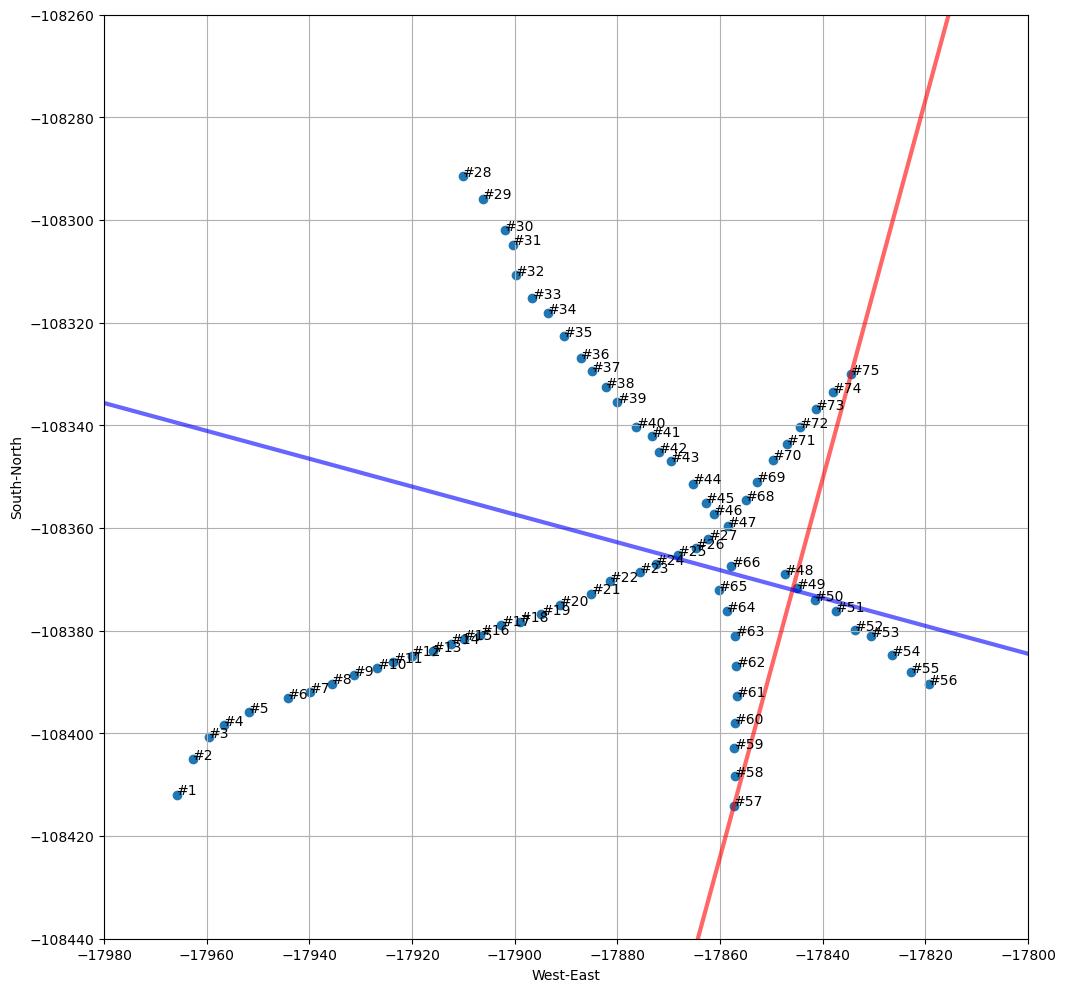

In [2]:
import xml.etree.ElementTree as ET
import requests, json, time
from pyproj import Transformer
import numpy as np;import matplotlib.pyplot as plt

firepits={}
tree = ET.parse('map.osm') # XMLファイル
root = tree.getroot()
for child in root.findall('node'):
    tags=child.findall('tag')
    if len(tags)==3 and tags[0].attrib['v']=='firepit':
        lat=float(child.attrib['lat'])
        lon=float(child.attrib['lon'])
        firepits[tags[1].attrib['v']]={'lat_lon':[lat,lon]}
for k,v in firepits.items():
    url='http://cyberjapandata2.gsi.go.jp/general/dem/scripts/getelevation.php?'+\
        f'lon={v["lat_lon"][1]}&lat={v["lat_lon"][0]}&outtype=JSON'
    v['elevation']=json.loads(requests.get(url).text)['elevation']
    time.sleep(3) # サーバ負荷を与えない
wgs84_to_rect6=Transformer.from_crs(
        'EPSG:4326', # WGS84
        'EPSG:2448', # 平面直角座標系Ⅵ(6)系
        always_xy=True) # 緯度経度順を横縦に統一
for k,v in firepits.items():
    ret=wgs84_to_rect6.transform(v["lat_lon"][1],
                                 v["lat_lon"][0])
    v['x']=ret[0];v['y']=ret[1]

fig,ax = plt.subplots(figsize=(12,12))
ax.scatter([v['x'] for v in firepits.values()],
            [v['y'] for v in firepits.values()])
for k,v in firepits.items():
    ax.annotate(k,(v['x'],v['y']))
# 一画目(一)の直線
ax.axline((firepits['#57']['x'], firepits['#57']['y']),
          (firepits['#75']['x'], firepits['#75']['y']),
          color=(1,0,0,0.6),lw=3)  # 2点指定
# 一画目(一)への垂線
center_x=(firepits['#57']['x']+firepits['#75']['x'])/2 #中点X座標
center_y=(firepits['#57']['y']+firepits['#75']['y'])/2 #中点Y座標
slope=-(firepits['#57']['x']-firepits['#75']['x']) \
         /(firepits['#57']['y']-firepits['#75']['y']) #傾き
goal_x=center_x-7000;goal_y=center_y-7000*slope #垂線が向かう先の点
ax.axline((center_x,center_y),(goal_x,goal_y),color=(0,0,1,0.6),lw=3)
ax.grid();plt.xlabel('West-East');plt.ylabel('South-North')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-17980,-17980+180]);plt.ylim([-108440,-108440+180]);plt.show()

## 大文字の火床配置を 3 次元的に眺めるコード

<IPython.core.display.Javascript object>


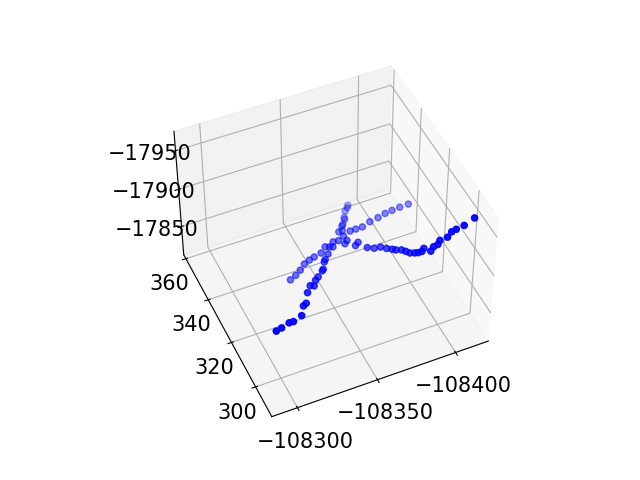

In [407]:
from matplotlib import pyplot as plt
import numpy as np
  
%matplotlib notebook
fig=plt.figure()
ax=fig.add_subplot(1,1,1,projection='3d')
z= [v['x'] for v in firepits.values()]
x= [v['y'] for v in firepits.values()]
y=[v['elevation'] for v in firepits.values()]
ax.scatter(x, y, z, c='b'); plt.show()

## 銀閣(慈照寺)・鴨川デルタ・相国寺・金閣(鹿苑寺)・愛宕神社は一本の直線上に乗る !?


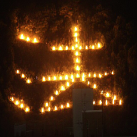
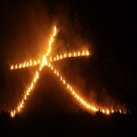
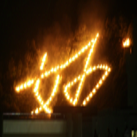
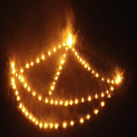
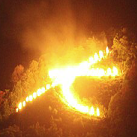
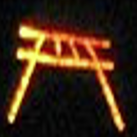
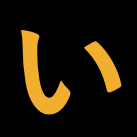
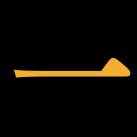
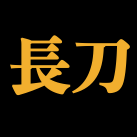
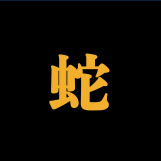

In [419]:
coordinates=[locs['慈照寺']['loc'],locs['愛宕神社']['loc']]
folium.PolyLine(locations=coordinates,color="#0000FF80",weight=8,).add_to(fmap)
fmap

## 断層や滑り地形を地図に重ねて表示すると、 地滑りで生じた三角末端面に大文字の火床は位置している


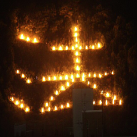
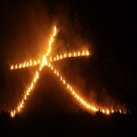
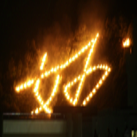
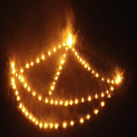
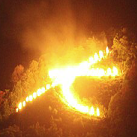
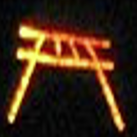
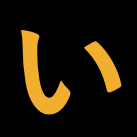
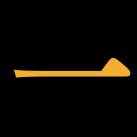
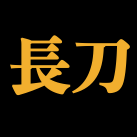
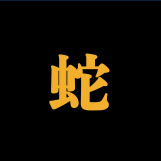

In [416]:
# 調査者	岡田篤正・東郷正美・中田　高・植村善博・渡辺満久
# https://maps.gsi.go.jp/#14/35.008733/135.802431/&base=std&ls=std%7Cafm%7Cafm_spec&blend=0&disp=111&lcd=afm_spec&vs=c1g1j0h0k0l0u0t0z0r0s0m0f1&d=m   

def add_layer(name,attr,opacity,fmap,url):
    folium.raster_layers.TileLayer(
        name=name,attr=attr,tiles=url,fmt='image/png',
        control=True,opacity=opacity,overlay=True,
    ).add_to(fmap)
add_layer('活断層図（都市圏活断層図）',
    '調査者:岡田篤正・東郷正美・中田　高・植村善博・渡辺満久',1.0,fmap,
    'https://cyberjapandata.gsi.go.jp/xyz/afm/{z}/{x}/{y}.png')
add_layer('地すべり地形分布図日本全国版(防災科学技術研究所)','防災科研',1.0,fmap,
    'https://www.j-shis.bosai.go.jp/map/xyz/landslide/{z}/{x}/{y}.png')
folium.LayerControl().add_to(fmap)
fmap